In [1]:
import pandas as pd
import numpy as np
from statsmodels.api import OLS, add_constant
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import json

In [2]:
NAIVE_COLOR: str = "red"
GRAPH_COLOR: str = "blue"
U_ETH_SPACE = [0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128]
U_ETH_SCALE = 1e7
NUMS_OF_TOKENS_SPACE = list(range(3, 13))
COLUMNS_ID = [
    'block_number', 'num_of_tokens', 'u_eth',
    'expected_gas', 'token_in', 'amount_in', 'amount_out', 'return_precost'
]
LEGEND_LINES = [Line2D([0], [0], color=NAIVE_COLOR, lw=2),
            Line2D([0], [0], color=GRAPH_COLOR, lw=2)]

In [3]:
def json_to_df(json_data):
    flatten_list = []
    for item in json_data:
        item_meta = item.copy()
        del item_meta["arbitrages"]
        for arb in item["arbitrages"]:
            new_item = item_meta.copy()
            new_item.update(arb)
            flatten_list.append(
                new_item
            )
    return pd.DataFrame(flatten_list).drop_duplicates(subset = COLUMNS_ID)

def json_to_meta_df(json_data):
    return pd.DataFrame(json_data)

def make_df(filenames: list[str]) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_flat = pd.DataFrame()
    df_meta = pd.DataFrame()
    for filename in filenames:
        u_eth_norm = float(filename.split("_")[-1].removesuffix(".json")) * U_ETH_SCALE
        try:
            with open(filename) as f:
                json_data = json.load(f)
                df_flat = pd.concat(
                    [
                        df_flat,
                        json_to_df(json_data).assign(
                            u_eth_norm = lambda df: u_eth_norm
                        ).assign(
                            log_u_eth_norm = lambda df: df["u_eth_norm"].pipe(np.log)
                        )
                    ]
                )
                df_meta = pd.concat(
                    [
                        df_meta,
                        json_to_meta_df(json_data)
                    ]
                )
        except FileNotFoundError:
            continue
    df_flat = df_flat.assign(
        eth_return_precost = lambda df: df["u_eth"].mul(df["return_precost"])
    ).assign(
        log_u_eth = lambda df: df["u_eth"].pipe(np.log)
    )

    return df_meta, df_flat

# Comparison Analysis
Modified graph vs naive

## Runtime Performance
Varying number of tokens

In [4]:
fixed_u_eth = 1
filenames_bf = [
    f"data/bf_test_{num_of_tokens}_{u_eth}.json"
    for num_of_tokens in NUMS_OF_TOKENS_SPACE + list(range(13, 16))
    for u_eth in U_ETH_SPACE
]

filenames_naive = [
    f"data/naive_test_{num_of_tokens}_{fixed_u_eth}.json"
    for num_of_tokens in NUMS_OF_TOKENS_SPACE
]

graph_meta_df, graph_df = make_df(filenames_bf)
naive_meta_df, naive_df = make_df(filenames_naive)

### Lower rate of change

Text(0, 0.5, 'Average runtime (s)')

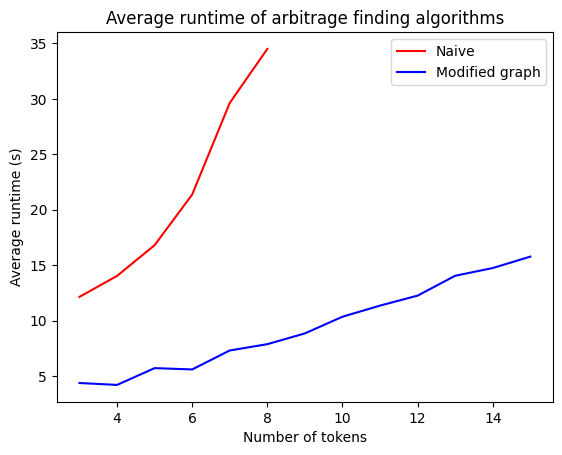

In [5]:
naive_meta_df.groupby(["num_of_tokens"])["time"].mean().plot(color = NAIVE_COLOR)
graph_meta_df.groupby(["num_of_tokens"])["time"].mean().plot(color = GRAPH_COLOR)
plt.legend(["Naive", "Modified graph"])
plt.title("Average runtime of arbitrage finding algorithms")
plt.xlabel("Number of tokens")
plt.ylabel("Average runtime (s)")

### More consistent

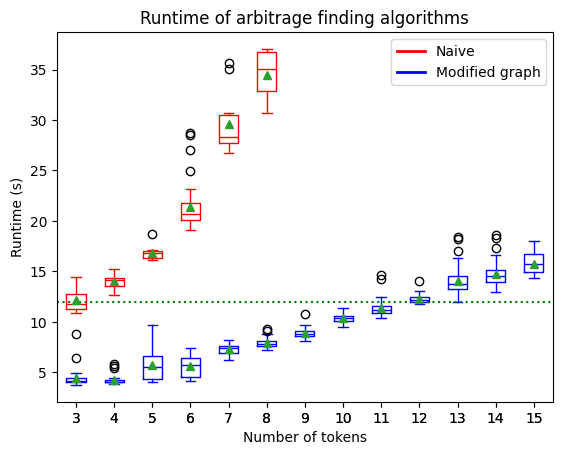

In [6]:
naive_box = naive_meta_df.groupby(["block_number", "num_of_tokens"])["time"].mean().reset_index().pivot(
    index = "block_number",
    columns = "num_of_tokens",
    values = "time"
).assign(
    **{
        str(i): np.nan
        for i in range(9, 16)
    }
).boxplot(color = NAIVE_COLOR, grid = False, showmeans = True)
bf_box = graph_meta_df.groupby(["block_number", "num_of_tokens"])["time"].mean().reset_index().pivot(
    index = "block_number",
    columns = "num_of_tokens",
    values = "time"
).boxplot(color = GRAPH_COLOR, grid = False, showmeans = True)

plt.legend(LEGEND_LINES, ["Naive", "Modified graph"])
plt.title("Runtime of arbitrage finding algorithms")
plt.xlabel("Number of tokens")
plt.ylabel("Runtime (s)")
plt.axhline(y = 12, color = "green", linestyle = "dotted")

### Fit of Order of Change

In [7]:
naive_time_df = naive_meta_df.assign(
    ln_num_of_tokens = lambda df: df["num_of_tokens"].pipe(np.log),
    n1 = lambda df: df["num_of_tokens"].pipe(lambda x: np.power(x, 1)),
    n2 = lambda df: df["num_of_tokens"].pipe(lambda x: np.power(x, 2)),
    n3 = lambda df: df["num_of_tokens"].pipe(lambda x: np.power(x, 3)),
    n4 = lambda df: df["num_of_tokens"].pipe(lambda x: np.power(x, 4)),
)

OLS(
    naive_time_df["time"],
    add_constant(naive_time_df[["n1", "n2"]])
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   time   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     343.3
Date:                Thu, 04 Apr 2024   Prob (F-statistic):           1.00e-41
Time:                        18:55:58   Log-Likelihood:                -191.34
No. Observations:                  89   AIC:                             388.7
Df Residuals:                      86   BIC:                             396.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.2479      2.934      5.878      0.000      11.415      23.081
n1            -4.1129      1.164     -3.533      0.001      -6.427      -1.799
n2             0.8085      0.111      7.267      0.000       0.587       1.030
==============================================================================
Omnibus:                       45.197   Durbin-Watson:                   1.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              125.514
Skew:                           1.780   Prob(JB):                     5.56e-28
Kurtosis:                       7.602   Cond. No.                         493.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
graph_time_df = graph_meta_df.assign(
    ln_num_of_tokens = lambda df: df["num_of_tokens"].pipe(np.log),
    n1 = lambda df: df["num_of_tokens"].pipe(lambda x: np.power(x, 1)),
    n2 = lambda df: df["num_of_tokens"].pipe(lambda x: np.power(x, 2)),
    n3 = lambda df: df["num_of_tokens"].pipe(lambda x: np.power(x, 3)),
    n4 = lambda df: df["num_of_tokens"].pipe(lambda x: np.power(x, 4)),
)

OLS(
    graph_time_df["time"],
    add_constant(graph_time_df[["n1", "n2", "n3"]])
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   time   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     1963.
Date:                Thu, 04 Apr 2024   Prob (F-statistic):               0.00
Time:                        18:55:58   Log-Likelihood:                -10954.
No. Observations:                4633   AIC:                         2.192e+04
Df Residuals:                    4629   BIC:                         2.194e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2492      0.542      7.840      0.000       3.187       5.312
n1            -0.4021      0.233     -1.728      0.084      -0.858       0.054
n2             0.1432      0.030      4.752      0.000       0.084       0.202
n3            -0.0044      0.001     -3.628      0.000      -0.007      -0.002
==============================================================================
Omnibus:                     2759.433   Durbin-Watson:                   0.521
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38866.065
Skew:                           2.590   Prob(JB):                         0.00
Kurtosis:                      16.210   Cond. No.                     1.45e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.45e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Accuracy and Robustness
Varying U

In [9]:
naive_fixed_num = 6
filenames_bf = [
    f"data/bf_test_{naive_fixed_num}_{u_eth}.json"
    for u_eth in U_ETH_SPACE
]

filenames_naive = [
    f"data/naive_test_{naive_fixed_num}_{u_eth}.json"
    for u_eth in U_ETH_SPACE
]

graph_meta_df, graph_df = make_df(filenames_bf)
naive_meta_df, naive_df = make_df(filenames_naive)

### Count

Text(0, 0.5, 'Count ratio')

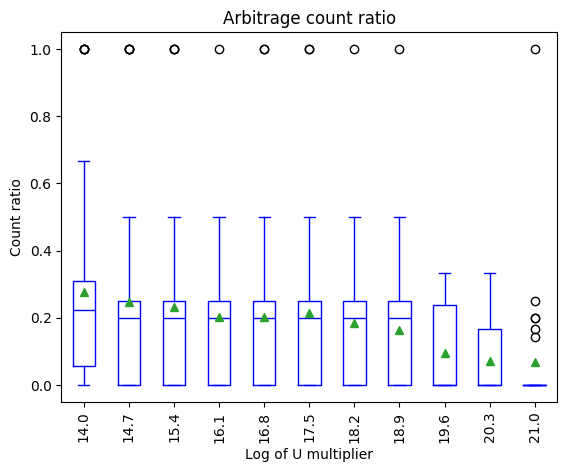

In [10]:
stats_count_df = naive_df.groupby(["block_number", "log_u_eth_norm"])["eth_return_precost"].count().reset_index().merge(
    graph_df.groupby(["block_number", "log_u_eth_norm"])["eth_return_precost"].count(),
    on = ["block_number", "log_u_eth_norm"],
    suffixes = ["_naive", "_graph"],
    how = "left"
).fillna(0).assign(
    eth_return_precost_ratio = lambda df: df["eth_return_precost_graph"].div(df["eth_return_precost_naive"])
)

stats_count_pivot = stats_count_df.pivot(
    index = "block_number", columns = "log_u_eth_norm", values = ["eth_return_precost_graph", "eth_return_precost_naive", "eth_return_precost_ratio"]
)


ax = stats_count_df.pivot(index = "block_number", columns = "log_u_eth_norm", values = "eth_return_precost_ratio").boxplot(color = "blue", rot = 90, grid = False, showmeans = True)
ax.set_xticklabels([round(float(x.get_text()), 1) for x in ax.get_xticklabels()])
plt.title("Arbitrage count ratio")
plt.xlabel("Log of U multiplier")
plt.ylabel("Count ratio")

In [60]:
stats_count_df.pivot(index = "block_number", columns = "log_u_eth_norm", values = "eth_return_precost_ratio").mean()

log_u_eth_norm
14.038654    0.277289
14.731801    0.248016
15.424948    0.231203
16.118096    0.201754
16.811243    0.201351
17.504390    0.215238
18.197537    0.182857
18.890684    0.164558
19.583832    0.096078
20.276979    0.071354
20.970126    0.067570
dtype: float64

Text(0, 0.5, 'Count')

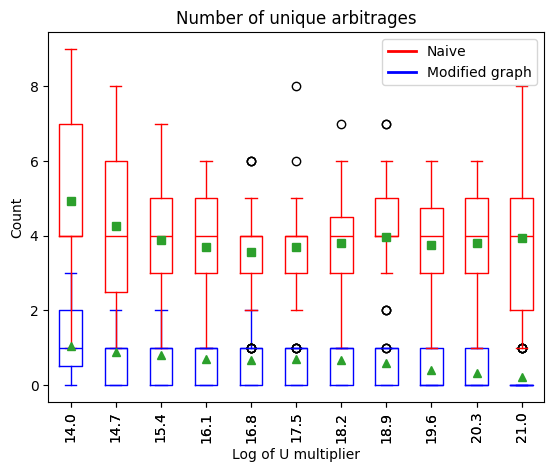

In [11]:
ax = stats_count_df.pivot(index = "block_number", columns = "log_u_eth_norm", values = "eth_return_precost_graph").boxplot(color = "blue", rot = 90, grid = False, showmeans = True)
ax = stats_count_df.pivot(index = "block_number", columns = "log_u_eth_norm", values = "eth_return_precost_naive").boxplot(color = "red", rot = 90, grid = False, showmeans = True, meanprops={"marker":"s"})
ax.set_xticklabels([round(float(x.get_text()), 1) for x in ax.get_xticklabels()])
plt.legend(LEGEND_LINES, ["Naive", "Modified graph"])
plt.title("Number of unique arbitrages")
plt.xlabel("Log of U multiplier")
plt.ylabel("Count")

### Sum

Text(0, 0.5, 'Total profit ratio')

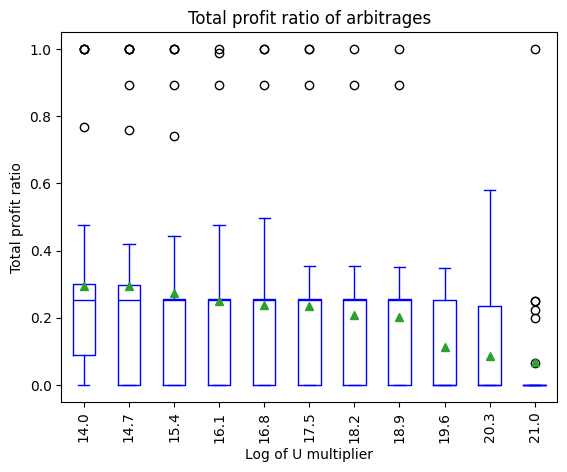

In [12]:
stats_sum_df = naive_df.groupby(["block_number", "log_u_eth_norm"])["eth_return_precost"].sum().reset_index().merge(
    graph_df.groupby(["block_number", "log_u_eth_norm"])["eth_return_precost"].sum(),
    on = ["block_number", "log_u_eth_norm"],
    suffixes = ["_naive", "_graph"],
    how = "left"
).fillna(0).assign(
    eth_return_precost_ratio = lambda df: df["eth_return_precost_graph"].div(df["eth_return_precost_naive"])
)
ax = stats_sum_df.pivot(index = "block_number", columns = "log_u_eth_norm", values = "eth_return_precost_ratio").boxplot(color = "blue", rot = 90, grid = False, showmeans = True)
ax.set_xticklabels([round(float(x.get_text()), 1) for x in ax.get_xticklabels()])
plt.title("Total profit ratio of arbitrages")
plt.xlabel("Log of U multiplier")
plt.ylabel("Total profit ratio")

In [59]:
stats_sum_df.pivot(index = "block_number", columns = "log_u_eth_norm", values = "eth_return_precost_ratio").mean()

log_u_eth_norm
14.038654    0.295501
14.731801    0.293133
15.424948    0.274488
16.118096    0.250169
16.811243    0.236444
17.504390    0.236223
18.197537    0.207443
18.890684    0.201190
19.583832    0.112159
20.276979    0.085333
20.970126    0.068467
dtype: float64

[Text(1, 0, '14.0'),
 Text(2, 0, '14.7'),
 Text(3, 0, '15.4'),
 Text(4, 0, '16.1'),
 Text(5, 0, '16.8'),
 Text(6, 0, '17.5'),
 Text(7, 0, '18.2'),
 Text(8, 0, '18.9'),
 Text(9, 0, '19.6'),
 Text(10, 0, '20.3'),
 Text(11, 0, '21.0'),
 Text(1, 0, '14.0'),
 Text(2, 0, '14.7'),
 Text(3, 0, '15.4'),
 Text(4, 0, '16.1'),
 Text(5, 0, '16.8'),
 Text(6, 0, '17.5'),
 Text(7, 0, '18.2'),
 Text(8, 0, '18.9'),
 Text(9, 0, '19.6'),
 Text(10, 0, '20.3'),
 Text(11, 0, '21.0')]

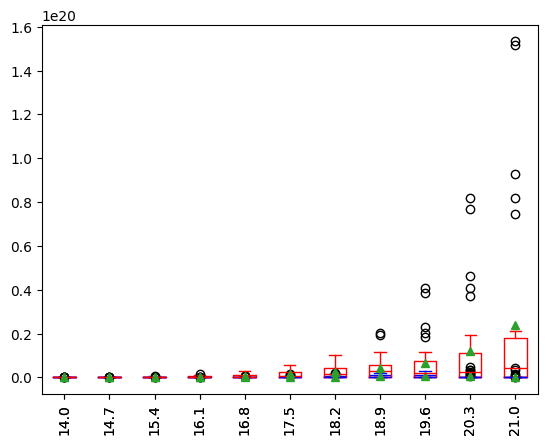

In [13]:
ax = stats_sum_df.pivot(index = "block_number", columns = "log_u_eth_norm", values = "eth_return_precost_graph").boxplot(color = "blue", rot = 90, grid = False, showmeans = True)
ax = stats_sum_df.pivot(index = "block_number", columns = "log_u_eth_norm", values = "eth_return_precost_naive").boxplot(color = "red", rot = 90, grid = False, showmeans = True)
ax.set_xticklabels([round(float(x.get_text()), 1) for x in ax.get_xticklabels()])

### Mean

Text(0, 0.5, 'Average profit ratio')

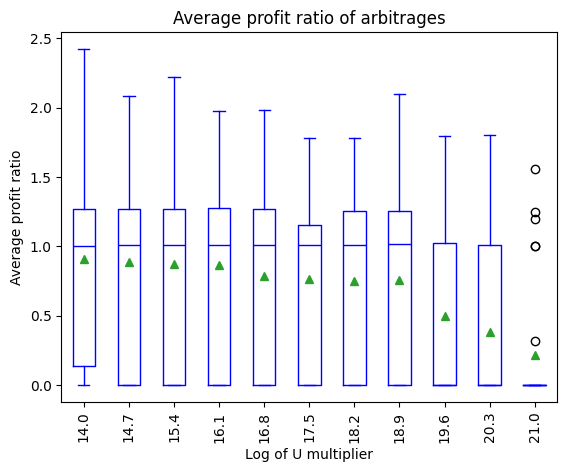

In [14]:
stats_mean_df = naive_df.groupby(["block_number", "log_u_eth_norm"])["eth_return_precost"].mean().reset_index().merge(
    graph_df.groupby(["block_number", "log_u_eth_norm"])["eth_return_precost"].mean(),
    on = ["block_number", "log_u_eth_norm"],
    suffixes = ["_naive", "_graph"],
    how = "left"
).fillna(0).assign(
    eth_return_precost_ratio = lambda df: df["eth_return_precost_graph"].div(df["eth_return_precost_naive"])
)

ax = stats_mean_df.pivot(index = "block_number", columns = "log_u_eth_norm", values = "eth_return_precost_ratio").boxplot(color = "blue", rot = 90, grid = False, showmeans = True)
ax.set_xticklabels([round(float(x.get_text()), 1) for x in ax.get_xticklabels()])
plt.title("Average profit ratio of arbitrages")
plt.xlabel("Log of U multiplier")
plt.ylabel("Average profit ratio")
# Negative skew

In [58]:
stats_mean_df.pivot(index = "block_number", columns = "log_u_eth_norm", values = "eth_return_precost_ratio").mean()

log_u_eth_norm
14.038654    0.909469
14.731801    0.886363
15.424948    0.869577
16.118096    0.861520
16.811243    0.785140
17.504390    0.760514
18.197537    0.751061
18.890684    0.759365
19.583832    0.494258
20.276979    0.380560
20.970126    0.217969
dtype: float64

[Text(1, 0, '14.0'),
 Text(2, 0, '14.7'),
 Text(3, 0, '15.4'),
 Text(4, 0, '16.1'),
 Text(5, 0, '16.8'),
 Text(6, 0, '17.5'),
 Text(7, 0, '18.2'),
 Text(8, 0, '18.9'),
 Text(9, 0, '19.6'),
 Text(10, 0, '20.3'),
 Text(11, 0, '21.0'),
 Text(1, 0, '14.0'),
 Text(2, 0, '14.7'),
 Text(3, 0, '15.4'),
 Text(4, 0, '16.1'),
 Text(5, 0, '16.8'),
 Text(6, 0, '17.5'),
 Text(7, 0, '18.2'),
 Text(8, 0, '18.9'),
 Text(9, 0, '19.6'),
 Text(10, 0, '20.3'),
 Text(11, 0, '21.0')]

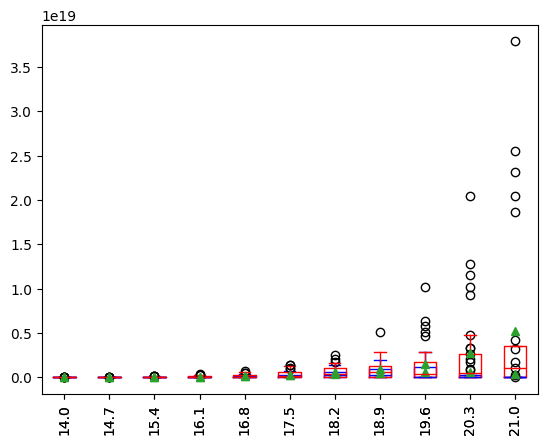

In [15]:
ax = stats_mean_df.pivot(index = "block_number", columns = "log_u_eth_norm", values = "eth_return_precost_graph").boxplot(color = "blue", rot = 90, grid = False, showmeans = True)
ax = stats_mean_df.pivot(index = "block_number", columns = "log_u_eth_norm", values = "eth_return_precost_naive").boxplot(color = "red", rot = 90, grid = False, showmeans = True)
ax.set_xticklabels([round(float(x.get_text()), 1) for x in ax.get_xticklabels()])

### Rank

Text(0, 0.5, 'Average rank')

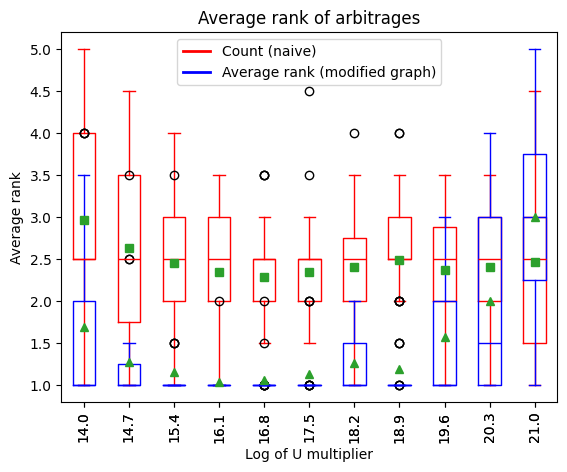

In [16]:
naive_arb_rank_df = naive_df.groupby(["block_number", "log_u_eth_norm"]).apply(
    lambda df: df.assign(
        arb_rank = lambda x: x["eth_return_precost"].rank(ascending = False),
        count = lambda x: x["eth_return_precost"].count()
    ).sort_values("arb_rank")
).reset_index(drop = True)
graph_arb_rank_df = graph_df.merge(
    naive_arb_rank_df,
    how = "left",
    on = COLUMNS_ID + ["log_u_eth_norm"],
    suffixes = ["_graph", "_naive"]
).assign(
    percentile = lambda df: df["arb_rank"].div(df["count"])
)

ax = naive_arb_rank_df.groupby(["block_number", "log_u_eth_norm"])["arb_rank"].mean().reset_index().pivot(index = "block_number", columns = "log_u_eth_norm", values = "arb_rank").boxplot(color = "red", rot = 90, grid = False, showmeans = True, meanprops={"marker":"s"})
ax = graph_arb_rank_df.groupby(["block_number", "log_u_eth_norm"])["arb_rank"].mean().reset_index().pivot(index = "block_number", columns = "log_u_eth_norm", values = "arb_rank").boxplot(color = "blue", rot = 90, grid = False, showmeans = True)
ax.set_xticklabels([round(float(x.get_text()), 1) for x in ax.get_xticklabels()])
plt.legend(LEGEND_LINES, ["Count (naive)", "Average rank (modified graph)"])
plt.title("Average rank of arbitrages")
plt.xlabel("Log of U multiplier")
plt.ylabel("Average rank")

Text(0, 0.5, 'Average percentile')

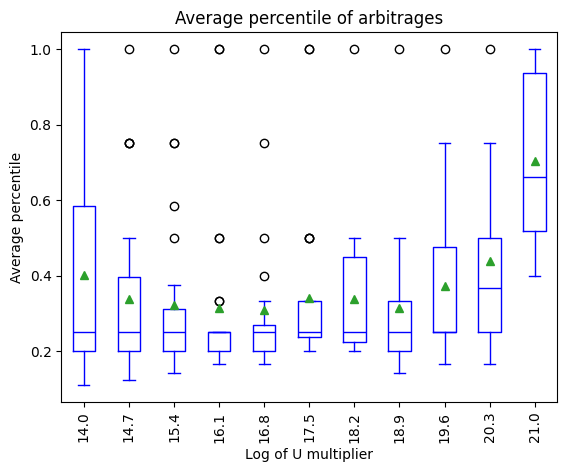

In [17]:
ax = graph_arb_rank_df.groupby(["block_number", "log_u_eth_norm"])["percentile"].mean().reset_index().pivot(index = "block_number", columns = "log_u_eth_norm", values = "percentile").boxplot(color = "blue", rot = 90, grid = False, showmeans = True)
ax.set_xticklabels([round(float(x.get_text()), 1) for x in ax.get_xticklabels()])
plt.title("Average percentile of arbitrages")
plt.xlabel("Log of U multiplier")
plt.ylabel("Average percentile")

In [56]:
graph_arb_rank_df.groupby(["block_number", "log_u_eth_norm"])["percentile"].mean().reset_index().pivot(index = "block_number", columns = "log_u_eth_norm", values = "percentile").mean()

log_u_eth_norm
14.038654    0.401437
14.731801    0.339506
15.424948    0.323489
16.118096    0.314103
16.811243    0.308333
17.504390    0.341667
18.197537    0.337681
18.890684    0.315533
19.583832    0.372619
20.276979    0.440000
20.970126    0.703571
dtype: float64

### Correlation

In [18]:
def create_hop_df(df: pd.DataFrame):
    hop_list = []
    for idx in range(len(df)):
        entry = df.iloc[idx].copy()
        for hop in entry["path"]:
            hop_list.append(
                {
                    "block_number": entry["block_number"],
                    "num_of_tokens": entry["num_of_tokens"],
                    "u_eth": entry["u_eth"],
                    "eth_return_precost": entry["eth_return_precost"],
                    "u_eth_norm": entry["u_eth_norm"],
                    "log_u_eth_norm": entry["log_u_eth_norm"],
                    "pool": hop["exchange_edge"]["exchange_function"]["swap_function"],
                    "path_length": len(entry["path"])
                }
            )
    return pd.DataFrame(hop_list)

In [19]:
naive_hop_df = create_hop_df(naive_df)
graph_hop_df = create_hop_df(graph_df)

Text(0, 0.5, 'Unique pool ratio')

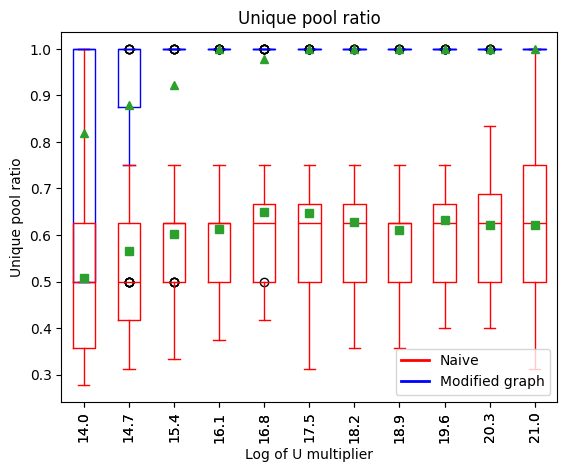

In [26]:
ax = graph_hop_df.groupby(["block_number", "log_u_eth_norm"]).apply(
    lambda df: df["pool"].nunique() / df["pool"].count()
).rename("unique_pool_ratio").reset_index().pivot(
    index = "block_number", columns = "log_u_eth_norm", values = "unique_pool_ratio"
).boxplot(color = GRAPH_COLOR, grid = False, showmeans = True, rot = 90)

ax = naive_hop_df.groupby(["block_number", "log_u_eth_norm"]).apply(
    lambda df: df["pool"].nunique() / df["pool"].count()
).rename("unique_pool_ratio").reset_index().pivot(
    index = "block_number", columns = "log_u_eth_norm", values = "unique_pool_ratio"
).boxplot(color = NAIVE_COLOR, grid = False, showmeans = True, rot = 90, meanprops={"marker":"s"})

ax.set_xticklabels([round(float(x.get_text()), 1) for x in ax.get_xticklabels()])
plt.legend(LEGEND_LINES, ["Naive", "Modified graph"])
plt.title("Unique pool ratio")
plt.xlabel("Log of U multiplier")
plt.ylabel("Unique pool ratio")

# Parameter Variation
On modified graph algorithm

In [35]:
filenames = [
    f"data/bf_test_{num_of_tokens}_{u_eth}.json"
    for num_of_tokens in NUMS_OF_TOKENS_SPACE
    for u_eth in U_ETH_SPACE
]

meta_df, arb_df = make_df(filenames = filenames)
arb_df = arb_df.groupby("block_number", group_keys = False).apply(
    lambda df: df.assign(
        eth_return_precost_norm = lambda x: x["eth_return_precost"].sub(x["eth_return_precost"].mean()).div(x["eth_return_precost"].std()),
        return_precost_norm = lambda x: x["return_precost"].sub(x["return_precost"].mean()).div(x["return_precost"].std())
    )
)

## Number of Tokens

<Axes: xlabel='num_of_tokens'>

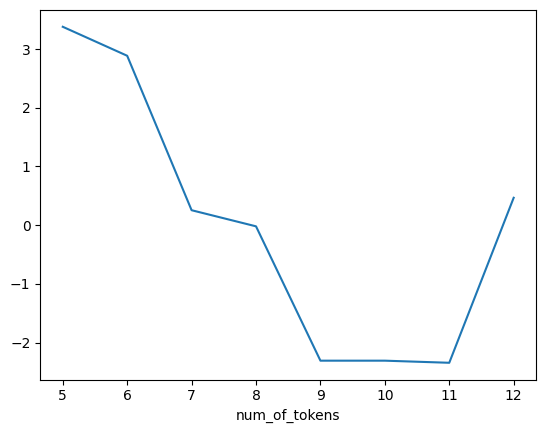

In [39]:
arb_df.groupby(["block_number", "num_of_tokens"])["return_precost_norm"].sum().reset_index().pivot(
    index = "block_number", columns = "num_of_tokens", values = "return_precost_norm"
).fillna(0).mean().plot()

<Axes: xlabel='num_of_tokens'>

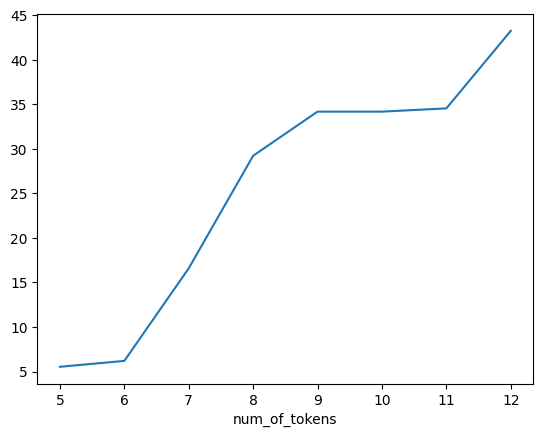

In [41]:
arb_df.groupby(["block_number", "num_of_tokens"])["return_precost_norm"].count().reset_index().pivot(
    index = "block_number", columns = "num_of_tokens", values = "return_precost_norm"
).fillna(0).mean().plot()

<Axes: xlabel='block_number'>

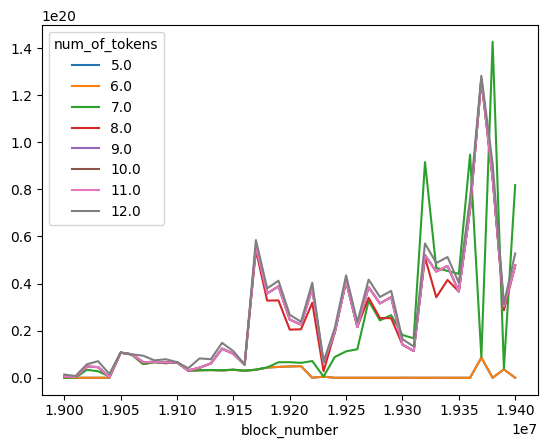

In [22]:
arb_df.groupby(["block_number", "num_of_tokens"])["eth_return_precost"].sum().reset_index().pivot(
    index = "block_number", columns = "num_of_tokens", values = "eth_return_precost"
).fillna(0).plot()

<Axes: xlabel='block_number'>

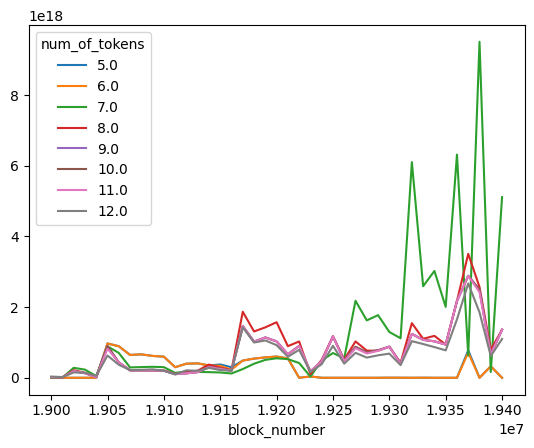

In [23]:
arb_df.groupby(["block_number", "num_of_tokens"])["eth_return_precost"].mean().reset_index().pivot(
    index = "block_number", columns = "num_of_tokens", values = "eth_return_precost"
).fillna(0).plot()

<Axes: xlabel='block_number'>

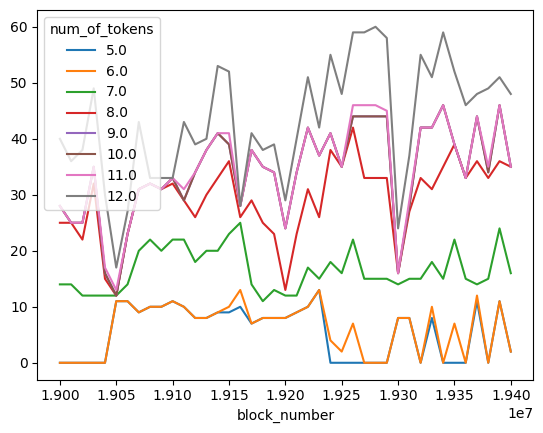

In [24]:
arb_df.groupby(["block_number", "num_of_tokens"])["eth_return_precost"].count().reset_index().pivot(
    index = "block_number", columns = "num_of_tokens", values = "eth_return_precost"
).fillna(0).plot()

## U

<Axes: xlabel='block_number'>

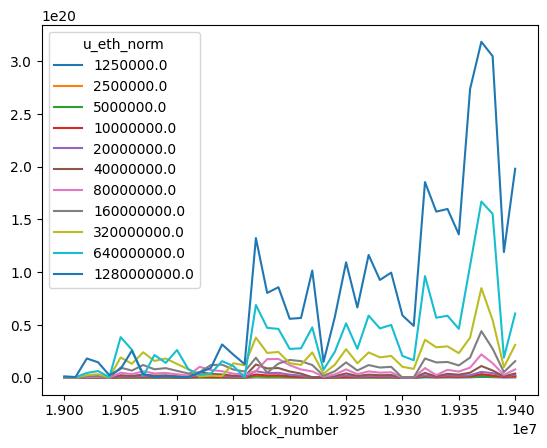

In [25]:
arb_df.groupby(["block_number", "u_eth_norm"])["eth_return_precost"].sum().reset_index().pivot(
    index = "block_number", columns = "u_eth_norm", values = "eth_return_precost"
).plot()

<Axes: xlabel='block_number'>

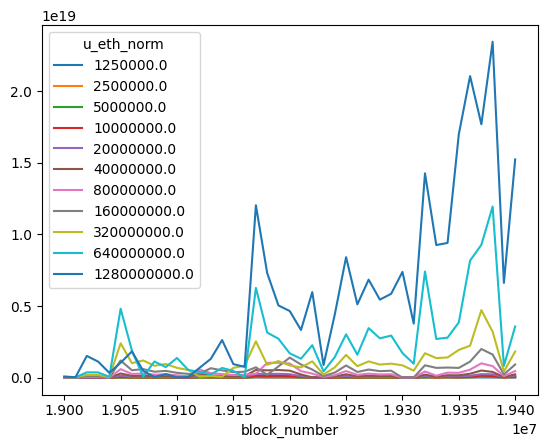

In [42]:
arb_df.groupby(["block_number", "u_eth_norm"])["eth_return_precost"].mean().reset_index().pivot(
    index = "block_number", columns = "u_eth_norm", values = "eth_return_precost"
).plot()

<Axes: xlabel='u_eth_norm'>

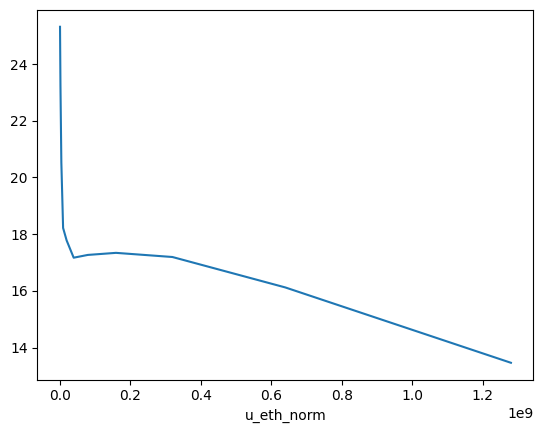

In [53]:
arb_df.groupby(["block_number", "u_eth_norm"])["eth_return_precost"].count().reset_index().pivot(
    index = "block_number", columns = "u_eth_norm", values = "eth_return_precost"
).plot()

<Axes: xlabel='u_eth_norm'>

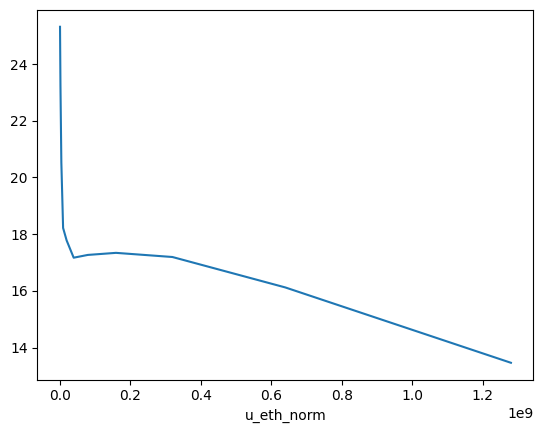

In [52]:
arb_df.groupby(["block_number", "u_eth_norm"])["return_precost_norm"].count().reset_index().pivot(
    index = "block_number", columns = "u_eth_norm", values = "return_precost_norm"
).mean().plot()

## Count decrease as U increase. Perhaps due to the algorithm being sensitive to implied exchange rate. As U increases, the slippage is increase, i.e. the implied exchange rate is decreased.
## limited liquidity 